PART 1: CONTEXT

One of the greatest problems facing 21st century American society is growing socioeconomic inequality. Nowhere is the issue more prevalent than in New York City, where the gap between the rich and poor is the greatest in the country.

There are no easy solutions to combat inequality. One approach is to address the problem at its roots: in education. With the largest public school system in the world, New York City faces unique challenges in educating its nearly 1.2 million students and preparing them for continued success once they leave the public school system.

They say proximity is destiny, and that is certainly true for the hundreds of thousands of students enrolling in public school each year. The NYC school system works by delineating districts, which are further segmented into zones. A student's eligibility for a school is determined by the zone and district in which he or she lives.

...
    
In New York City, Mayor Bill deBlasio, to no small amount of criticism, has revealed a plan to integrate schools.

This analysis studies five sets of data recorded over the 2016-2017 school year, and attempts to portray the relationship between geography, demography, and student success.

Furthermore, we will consider other types of diversity and, more importantly, other definitions of success, and display how this analysis can be retooled to compare the relationship between the two.

PART 2: HYPOTHESIS & SCOPE/VARIABLE DEFINITION

HYPOTHESIS

Racial diversity has a positive impact on student outcomes.

SCOPE & VARIABLE DEFINITION

Data was selected from public schools registered with a DBN that corresponds to one of 32 districts, so that diversity could be mapped per district. Only the 2016-2017 school year, where the datasets overlapped, was examined.

Datasets used:
https://data.cityofnewyork.us/Education/2016-2017-Graduation-Outcomes-School/nb39-jx2v
https://data.cityofnewyork.us/Education/School-Point-Locations/jfju-ynrr
https://data.cityofnewyork.us/Education/School-Districts/r8nu-ymqj
https://data.cityofnewyork.us/Education/2013-2018-Demographic-Snapshot-School/s52a-8aq6

Coaxing 'diversity' and 'success' into a quantifiable metric was an interesting task that certainly deserves more study. Note that here, "diversity" refers only to racial/ethnic diversity. Here is how I quantified both:

DIVERSITY INDEX

Four races are recorded in the demographics data: Asian, White, Black, and Hispanic. One can assume that a perfectly integrated school would have a population in which the distribution of students from each race is uniform, that is, that no one racial group is represented more than another. That means if a school was segmented by four races, each race would represent 25% of the population.

There is, however, an additional column representing "% Multiple Race Categories Not Represented," which complicated how the diversity index would be created. A cursory statistical summary of the "Not Represented" demography shows us:

mean        2.386269
std         2.689389
min         0.000000
25%         0.800000
50%         1.600000
75%         2.900000
max        29.700000

The distribution of "Not Represented" races was not insignificant (at most, "Not Represented" races accounted for almost 1/3 of the student body) and had to be taken into account in calculating the final diversity index.

Taking this information into account, I created the following metric to determine racial diversity:

Let o = % Multiple Race Categories Not Represented
Let total = 100 - o
Let target = total / 4
Let sum = |target - i|     where i = Asian, White, Black, and Hispanic
Let d_index = sum * (1/o)

1/o increases the d_index when o is small, and decreases the d_index when o is large, capturing the notion that a greater number of unrepresented races should indicate greater racial diversity.

The diversity index algorithm is implemented in the function d_index.

SUCCESS INDEX



PART 3: DATA MUNGING & SYNTHESIS

The first task in producing my final data visualization/analysis was to synthesize the data. I worked primarily with ESRI and csv data formats, where the ESRI files held my geospatial information and the csv files held data about the variables and outcomes I wanted to study. Since I wanted to display my analysis geospatially, I extracted the information I needed from the csv files and added it to the ESRI shapefiles.

The first step was to extract the relevant data from the csv files--one recording demographics data, and the other school outcome data.

In [ ]:
# IMPORTING & CLEANING DEMOGRAPHICS DATA FROM .CSV

# import shapefile into dataframe
# synthesize shapefile and csv data in dataframe
# how to repeat this task in the future to analyze new variables?

import pandas as pd
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

demodf = pd.read_csv('demographics.csv')
demodf.head()

# remove all non '16-'17 info, grade k-twelve encapsulated in total enrollment
# remove non-public schools
demodf = demodf[demodf.Year == '2016-17']
demodf = demodf.drop(["Grade K", "Grade 1", "Grade 2", "Grade 3",  "Grade 4", "Grade 5",
                      "Grade 6", "Grade 7", "Grade 8", "Grade 9", "Grade 10", "Grade 11",
                      "Grade 12", "Grade PK (Half Day & Full Day)", "Year"], axis = 1)

# public 
demodf.head()

demodf[['DBN', 'School Name']]
#print(demodata.DBN.unique())

# i visually inspected the resultant demodf, because couldn't find
# straightforward answer on how DBN corresponds to district#. found initial numbers
# corresponded to district. got index and dropped rows

demodf = demodf.reset_index()

#print(demodf[demodf['DBN']=='75K004'].index.item())

demodf = demodf[:1544]

features = list(demodf.columns.values)

features

# wanted to find how to incorporate 'other' race category
#demodf['% Multiple Race Categories Not Represented'].sort_values()

demodf['DBN']


In [ ]:
# CALCULATE DIVERSITY INDEX OF EACH SCHOOL & ADD TO DEMODF DATAFRAME
demodf['Diversity Index'] = 1

def d_index(row):
    o = row['% Multiple Race Categories Not Represented']
    total = 100 - o
    target = total / 4
    abs_distance = (abs(target - row['% Asian'])) + abs((target - row['% Black'])) + abs((target - row['% Hispanic'])) + abs((target - row['% White']))    
    if o == 0.0:
        return abs_distance 
    if o > 0.0:
        # diversity index
        return abs_distance * (1/o)
    
# append diversity index to demodf
demodf['Diversity Index'] = demodf.apply(d_index, axis=1)

demodf.head()

In [ ]:
district_keys = ["%.2d" % i for i in range(33)]

# SEGMENT DATAFRAME BY DISTRICT NUBER
for i in range(1,33):
    district_keys[i] = demodf.loc[demodf['DBN'].str.startswith(district_keys[i])]

# GET AVERAGE DIVERSITY INDEX BY DISTRICT
for i in range(1,33):
    district_keys[i] = (district_keys[i]['Diversity Index'].sum())/float(len(district_keys[i]))

district_keys = dict(zip(["%.2d" % i for i in range(33)], district_keys))

district_keys

In [ ]:
# TODO

# WRITE DIVERSITY INDEX TO SHAPEFILE

import osgeo
# driver = ogr.GetDriverByName('ESRI Shapefile')
# dataSource = driver.Open(“c:/test/Test2.shp”, 1) #1 is read/write

# #define floating point field named DistFld and 16-character string field named Name:
# fldDef = ogr.FieldDefn('diversity_index', ogr.OFTReal)

# #get layer and add the 2 fields:
# layer = dataSource.GetLayer()
# layer.CreateField(fldDef)
# layer.CreateField(fldDef2)

import shapefile
sf = shapefile.Reader('districts')

sf.shapes()

# READING SHAPEFILES
# list of fields
sf.fields

# .iterRecords() to iterate thru rows
records = list(sf.iterRecords())

records

# to get a single record by index
#rec = sf.record(0)

# WRITING SHAPEFILES

# instantiate writer class
#w = shapefile.Writer()

# creating attributes
# Creating attributes involves two steps.
# Step 1 is to create fields to contain attribute values
# Step 2 is to populate the fields with values for each shape record.
#

In [ ]:
# IMPORTING & CLEANING OUTCOMES DATA FROM .CSV

In [ ]:
# CALCULATE DIVERSITY INDEX OF EACH SCHOOL & ADD TO DEMODF DATAFRAME

In [ ]:
# SEGMENT DATAFRAME BY DISTRICT NUBER

# GET AVERAGE SUCCESS INDEX BY DISTRICT

In [ ]:
# WRITE SUCCESS INDEX TO SHAPEFILE

import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 4000

odf = pd.read_csv('outcomes.csv')
odf.head()


UnicodeDecodeError: 'utf8' codec can't decode byte 0xa0 in position 7: invalid start byte

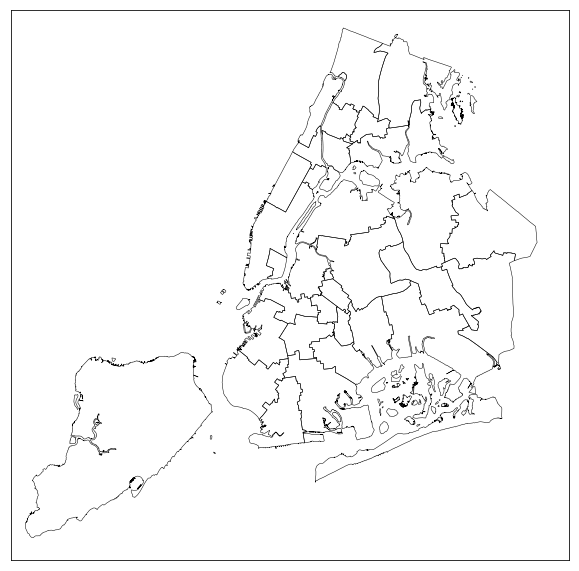

In [9]:
# DRAWING MAP

import matplotlib.pyplot as plt
import matplotlib.cm
import io

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from mpl_toolkits.basemap import Basemap


fig, ax = plt.subplots(figsize=(10,20))
m = Basemap(resolution='c', # c, l, i, h, f or None
            projection='merc',
            lat_0=40.700, lon_0=73.973,
            llcrnrlon=-74.2714, llcrnrlat= 40.4774, urcrnrlon=-73.6657, urcrnrlat=40.93)

#m.drawmapboundary(fill_color='#46bcec')
#m.fillcontinents(color='#f2f2f2')
#m.drawcoastlines()
m.readshapefile('districts', 'districts')

# decoding issue for .dbf file
# for item in DBF('locations.dbf', encoding='iso-8859-1'):
#     print(item)

m.readshapefile('locations', 'locations')
    

In [ ]:
# COLOR IN MAP

# Populating DataFrame from shapefile
df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.areas],
        'area': [area['name'] for area in m.areas_info]
    })
df_poly = df_poly.merge(new_areas, on='area', how='left')

# Coloring key

cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()

pc.set_facecolor(cmap(norm(df_poly['count'].fillna(0).values)))
ax.add_collection(pc)


In [ ]:
# PLOT SCHOOL LOCATION DATA POINTS

PART 5: CONCLUSIONS, IMPLICATIONS, RAMIFICATIONS

PART 6: TOOL EXTENSION

1. Other types of listed 'diversity': gender, % with disabilities, % poverty, economic need index...
2. Other types of 'student success': total regents %, advanced regents, still enrolled, droppped out...

Aare there any other measures of 'success' that would tell us about the nuanced benefits of an integrated school? How about a more lateral success: same average, but more equally distributed 'success'...

Something about k-nearest neighbors

https://tcf.org/content/facts/the-benefits-of-socioeconomically-and-racially-integrated-schools-and-classrooms/?agreed=1&session=1

https://infohub.nyced.org/reports-and-policies/school-quality/nyc-school-survey/survey-archives